In [4]:
import os
BASE_DIR = './runs'
import math
os.makedirs(BASE_DIR, exist_ok=True)
import random
import torch
import os
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torch.nn.utils.rnn import pad_sequence
from utils import config
from data_utils import dataset
from model import vit
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from model.loss import ContrastiveLoss, ContrastiveSoftMax

#sets random
random_seed=42
random.seed(42)
torch.manual_seed(random_seed)

device="cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu" )

match device:
    case "cuda":
        torch.cuda.manual_seed_all(random_seed)
    case "mps":
        torch.mps.manual_seed(random_seed)

import gc
gc.collect()
torch.cuda.empty_cache()
conf = config.load_config("configs/stage_contrastive.yaml")

In [2]:
#GloVe
glove_file = './datasets/glove.6B.300d.txt'
word2vec_temp_file = get_tmpfile("glove_word2vec.txt")
glove2word2vec(glove_file, word2vec_temp_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_temp_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_temp_file)
class Tokenizer:
    def __init__(self, embeding_model):
        self.embeddings = embeding_model
    
    def tokenize(self, sent_tokens):
        tokens_embeddings = []
        for t in sent_tokens:
            if t in self.embeddings:
                tokens_embeddings.append(self.embeddings[t])
            else:
                tokens_embeddings.append(np.zeros(300))
        return torch.FloatTensor(tokens_embeddings)

tokenizer = Tokenizer(glove_model)

In [3]:

image_embeder = vit.ImgEncoder(**conf['model']['ImageEncoder'])
text_embeder = vit.TextConvEncoder(**conf['model']['TextConvEncoder'])
siam_model = vit.SiamEncoder(**conf['model']['SiamEncoder'])
siam_model_params = list(image_embeder.parameters()) + list(text_embeder.parameters()) + list(siam_model.parameters())
optimizer = torch.optim.AdamW(siam_model_params,  **conf['optimizer_params'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=conf['train_settings']['milestones'],
            gamma=conf['train_settings']['lr_decay']
        )
scaler = torch.cuda.amp.GradScaler()
losses = []
val_scores = []
(sum(p.numel() for p in image_embeder.parameters() if p.requires_grad), 
sum(p.numel() for p in text_embeder.parameters() if p.requires_grad), 
sum(p.numel() for p in siam_model.parameters() if p.requires_grad))

(7347456, 816768, 28521985)

In [4]:
import json
def save_checkpoint(path_to_checkpoints_folder, checkpoint_name, conf, text_embedder, img_embedder, siam_model, optimizer, scheduler, scaler, train_losses, val_scores):
    """
    Save model, config, score
    """
    path_to_checkpoint = os.path.join(path_to_checkpoints_folder, checkpoint_name)
    os.makedirs(path_to_checkpoint, exist_ok=True)
    config.dump_config(path_to_checkpoint, conf, 'config.yaml')

    path_to_metrics = os.path.join(path_to_checkpoint, 'metrics.json')
    with open(path_to_metrics, 'w') as f:
        json.dump({'train_losses': train_losses, 'val_scores': val_scores}, f, indent=4)
    
    path_to_model = os.path.join(path_to_checkpoint, 'model.pt')
    torch.save(
                {
                    'text_embedder_state_dict': text_embedder.state_dict(),
                    'img_embedder_state_dict': img_embedder.state_dict(),
                    'siam_model_state_dict': siam_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    "scaler_state_dict": scaler.state_dict()
                
                },
                path_to_model
                )

def load_checkpoint(path_to_checkpoints_folder, checkpoint_name, device):
    path_to_data = os.path.join(path_to_checkpoints_folder, checkpoint_name)
    conf = config.load_config(os.path.join(path_to_data, 'config.yaml'))

    with open(os.path.join(path_to_data, 'metrics.json'), 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    val_scores = data['val_scores']

    path_to_model = os.path.join(path_to_data, 'model.pt')
    model_state = torch.load(path_to_model, map_location=device)
    image_embeder = vit.ImgEncoder(**conf['model']['ImageEncoder'])
    text_embeder = vit.TextConvEncoder(**conf['model']['TextConvEncoder'])
    siam_model = vit.SiamEncoder(**conf['model']['SiamEncoder'])
    scaler = torch.cuda.amp.GradScaler()
    image_embeder.load_state_dict(model_state['img_embedder_state_dict'])
    text_embeder.load_state_dict(model_state['text_embedder_state_dict'])
    siam_model.load_state_dict(model_state['siam_model_state_dict'])
    scaler.load_state_dict(model_state['scaler_state_dict'])


    image_embeder = image_embeder.to(device)
    text_embeder = text_embeder.to(device)
    siam_model = siam_model.to(device)

    siam_model_params = torch.nn.ModuleList([image_embeder, text_embeder, siam_model])
    optimizer = torch.optim.AdamW(siam_model_params.parameters(), **conf['optimizer_params'])
    optimizer.load_state_dict(model_state['optimizer_state_dict'])

    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, 
        milestones=conf['train_settings']['milestones'], 
        gamma=conf['train_settings']['lr_decay'])
    return image_embeder, text_embeder, siam_model, optimizer, scheduler, conf, scaler, train_losses, val_scores

In [ ]:
image_embeder, text_embeder, siam_model, optimizer, scheduler, conf, scaler, losses, val_scores = load_checkpoint(BASE_DIR, "epoch_46", device)
siam_model_params = torch.nn.ModuleList([image_embeder, text_embeder, siam_model])

FileNotFoundError: [Errno 2] No such file or directory: './runs/epoch_46/config.yaml'

In [5]:
SEQ_LEN = conf['model']['TextConvEncoder']['seq_len']

def tokenize_sent_batch(sents_batch):
    tokenized_sentences = []
    length_list = []
    for sent in sents_batch:
        sent_tokens = sent.strip().split()
        if len(sent_tokens) > SEQ_LEN:
            sent_tokens = sent_tokens[:SEQ_LEN]
        tokenized_sentences.append(tokenizer.tokenize(sent_tokens))
        length_list.append(len(sent_tokens))
    #pad sequences to Text Embeder len
    tokenized_sentences[0] = torch.concat((tokenized_sentences[0], torch.zeros(SEQ_LEN - length_list[0], 300)), dim=0)
    seqs = pad_sequence(tokenized_sentences, batch_first=True)
    return seqs, torch.tensor(length_list, dtype=torch.uint8)


def pading_sentences_fn(data):
    masks_tensors, sents= zip(*data)
    masks_tensors = torch.stack(masks_tensors)
    sents, lens = tokenize_sent_batch(sents)
    return masks_tensors, sents, lens


train_dataset = dataset.ReferenceDataset(
    **conf['data']['train'],
)
train_data_coco_plus = dataset.ReferenceDataset(
    **conf['data']['train_plus'],
)
union_train_dataset = ConcatDataset([train_dataset, train_data_coco_plus])
train_data = DataLoader(
    union_train_dataset,
    batch_size=conf['train_settings']['batch_size'],
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=6,
    collate_fn=pading_sentences_fn
)

val_dataset = dataset.ReferenceDataset(
    **conf['data']['val'],
)
val_dataset_plus = dataset.ReferenceDataset(
    **conf['data']['val_plus'],
)
union_val_dataset = ConcatDataset([val_dataset, val_dataset_plus])
val_data = DataLoader(
    union_val_dataset,
    batch_size=conf['train_settings']['batch_size'],
    shuffle=False,
    pin_memory=True,
    drop_last=True,
    num_workers=6,
    collate_fn=pading_sentences_fn
)
epoch = (conf['train_settings']['start_epoch'], conf['train_settings']['epochs'])

In [6]:
class Trainer:
    def __init__(self, text_embedder, img_embedder, siam_model, optimizer, checkpoint_path, scheduler, conf, scaler, device="cpu", tb_path=None):
        self.text_embedder = text_embedder.to(device)
        self.img_embedder = img_embedder.to(device)
        self.siam_model = siam_model.to(device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.tb_path = tb_path
        self.checkpoint_path = checkpoint_path
        self.loss_fn = ContrastiveSoftMax(batch_size=conf['train_settings']['batch_size'],  temperature=1.0).to(device)
        self.conf = conf
        self.scaler=scaler
        if self.tb_path is not None:
            self.writer =  SummaryWriter(self.checkpoint_path, self.tb_path)

    def train(self, train_data, val_data, epochs, losses, val_scores, checkpoint_step=1, scheduler_step=1, scaler_step=1):
        if self.tb_path is not None:
          for i, ls in enumerate(losses):
            self.writer.add_scalar("Loss_epoche/train", ls, i)
          for i, vl in enumerate(val_scores):
            self.writer.add_scalar("MSE/val", vl, i)
        for epoch in tqdm(range(epochs[0], epochs[1]), desc='Epochs'):
            train_loss = self.train_epoch(train_data, epoch, scaler_step)
            val_acc, cosine_acc, snx_loss = self.validate(val_data)
            if self.tb_path is not None:
                self.writer.add_scalar("Cosine/val", cosine_acc , epoch )
                self.writer.add_scalar("Loss_epoche/train", train_loss, epoch)
                self.writer.add_scalar("MSE/val", val_acc, epoch)
                self.writer.add_scalar("SN-XTENT/val", snx_loss, epoch)
            print(f"Epoch: {epoch}/{epochs} - Loss: {train_loss:.4f}")
            losses.append(train_loss)
            val_scores.append(val_acc)
            if (epoch + 1) % scheduler_step == 0:
                self.scheduler.step()
            if (epoch + 1) % checkpoint_step == 0 and epoch != 0:
                self.conf['train_settings']['start_epoch'] = epoch + 1
                save_checkpoint(
                    self.checkpoint_path,
                    f'epoch_{epoch}',
                    self.conf,
                    self.text_embedder,
                    self.img_embedder,
                    self.siam_model,
                    self.optimizer,
                    self.scheduler,
                    self.scaler,
                    losses,
                    val_scores
                    )

    def train_epoch(self, train_data, epoch, scaler_step):
        self.img_embedder.train()
        self.text_embedder.train()
        self.siam_model.train()
        img_embedder = torch.compile(self.img_embedder, mode='max-autotune', fullgraph=True)
        text_embedder = torch.compile(self.text_embedder, mode='max-autotune', fullgraph=True)
        siam_model = torch.compile(self.siam_model, mode='max-autotune', fullgraph=True)
        loss = []
        self.optimizer.zero_grad()
        for step, (masks_tensor, sents, _,) in enumerate(tqdm(train_data, desc="Training", leave=False)):
            #calc step
            with torch.autocast(device_type=self.device):
                masks_tensor = masks_tensor.to(self.device, non_blocking=True)
                sents = sents.to(self.device, non_blocking=True)
                img_embeddings = img_embedder(masks_tensor)
                text_embeddings = text_embedder(sents)
                img_encoded, _ = siam_model(img_embeddings)
                text_encoded, _ = siam_model(text_embeddings)
                step_loss = self.loss_fn(img_encoded, text_encoded)
            self.scaler.scale(step_loss).backward()
            if (step + 1) % scaler_step == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
            step_loss = step_loss.cpu().detach().item()
            loss.append(step_loss)
            if self.tb_path is not None:
                self.writer.add_scalar("Contrastive_loss/train", step_loss, epoch * len(train_data) + step)
        return np.mean(loss)


    @torch.no_grad()
    def validate(self, val_data):
        self.img_embedder.eval()
        self.text_embedder.eval()
        self.siam_model.eval()
        mse_acc = []
        coss_acc = []
        snx = []
        mse = torch.nn.functional.mse_loss
        cos_los = torch.nn.functional.cosine_embedding_loss
        csm_loss = ContrastiveSoftMax(batch_size=self.conf['train_settings']['batch_size'],  temperature=1.0).to(self.device)
        for _, (masks_tensor, sents, _) in enumerate(tqdm(val_data, desc="Validating", leave=False)):
            with torch.autocast(device_type=self.device):
                masks_tensor = masks_tensor.to(self.device, non_blocking=True)
                sents = sents.to(self.device, non_blocking=True)
                img_embeddings = self.img_embedder(masks_tensor)
                text_embeddings = self.text_embedder(sents)
                img_encoded, _ = self.siam_model(img_embeddings)
                text_encoded, _ = self.siam_model(text_embeddings)
                mse_loss = mse(img_encoded, text_encoded)
                cs = cos_los(img_encoded, text_encoded, torch.ones((sents.size()[0])).to(self.device))
                csm = csm_loss(img_encoded, text_encoded)
                coss_acc.append(cs.cpu().detach().item())
                mse_acc.append(mse_loss.cpu().detach().item())
                snx.append(csm.cpu().detach().item())
        return np.mean(mse_acc), np.mean(coss_acc), np.mean(snx)

In [7]:
trainer = Trainer(text_embeder, image_embeder, siam_model, optimizer, BASE_DIR, scheduler, conf, scaler, device, 'tb')
gc.collect()
torch.cuda.empty_cache()

In [8]:
trainer.train(train_data, val_data, epoch, losses, val_scores, scaler_step=conf['train_settings']['scaler_step'], checkpoint_step=conf['train_settings']['checkpoint_step'])

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/1764 [00:00<?, ?it/s]

W0523 12:06:35.892000 139979698008064 torch/_inductor/utils.py:945] [0/0] not enough SMs to use max_autotune_gemm mode
AUTOTUNE addmm(8160x1536, 8160x384, 384x1536)
  addmm 0.3461 ms 100.0%
  bias_addmm 0.3594 ms 96.3%
SingleProcess AUTOTUNE takes 0.4966 seconds
AUTOTUNE addmm(1248x1536, 1248x384, 384x1536)
  bias_addmm 0.0687 ms 100.0%
  addmm 0.0717 ms 95.9%
SingleProcess AUTOTUNE takes 0.3040 seconds


Validating:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 0/(0, 300) - Loss: 2.3468


Training:   0%|          | 0/1764 [00:00<?, ?it/s]

Validating:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1/(0, 300) - Loss: 2.1220


Training:   0%|          | 0/1764 [00:00<?, ?it/s]

Validating:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2/(0, 300) - Loss: 2.1163


Training:   0%|          | 0/1764 [00:00<?, ?it/s]

Validating:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3/(0, 300) - Loss: 2.0628


Training:   0%|          | 0/1764 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
from datasets import load_dataset, DatasetDict
ds = load_dataset("embedding-data/coco_captions")
train_testvalid = ds['train'].train_test_split(test_size=0.1)
ds = DatasetDict(
    {
        'train': train_testvalid['train'],
        'val': train_testvalid['test']
    })

In [65]:
ds

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 74504
    })
    val: Dataset({
        features: ['set'],
        num_rows: 8279
    })
})

In [6]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from datasets import load_dataset, DatasetDict

ds = load_dataset("embedding-data/coco_captions")
train_testvalid = ds['train'].train_test_split(test_size=0.1)
ds = DatasetDict(
    {
        'train': train_testvalid['train'],
        'val': train_testvalid['test']
    })

class TextPairsDataset(Dataset):
    def __init__(self, data, accessor):
        self.data = data
        self.accessor = accessor
        self.len = len(self.accessor(self.data))
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        choises = len(self.accessor(self.data)[index])
        x, y = np.random.choice(choises, 2)
        return self.accessor(self.data)[index][x], self.accessor(self.data)[index][y]


text_train_dataset = TextPairsDataset(ds['train'], lambda x: x['set'])
text_val_dataset = TextPairsDataset(ds['val'], lambda x: x['set'])

def pading_sentences_fn(data):
    sents1, sents2 = zip(*data)
    sents1, _ = tokenize_sent_batch(sents1)
    sents2, _ = tokenize_sent_batch(sents2)
    return sents1, sents2

text_train_dataset = TextPairsDataset(ds['train'], lambda x: x['set'])
text_val_dataset = TextPairsDataset(ds['val'], lambda x: x['set'])
text_train_dataloader = DataLoader(
    text_train_dataset,
    batch_size=conf['train_settings']['batch_size'],
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=6,
    collate_fn=pading_sentences_fn
)
text_val_dataloader = DataLoader(
    text_val_dataset,
    batch_size=conf['train_settings']['batch_size'],
    shuffle=False,
    pin_memory=True,
    drop_last=True,
    num_workers=6,
    collate_fn=pading_sentences_fn
)

In [122]:
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import v2
from data_utils.dataset import affine_transform, ReferenceDataset
import cv2
import numpy as np

class custom_augmentation(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, target):
        open_cv_image = np.array(img)
        open_cv_image = open_cv_image[:, :, ::-1].copy()
        open_cv_mask = np.array(target.convert('L'))
        open_cv_mask = open_cv_mask.astype(np.uint8).copy()
        mat, _ = ReferenceDataset.get_transform_mat(open_cv_image.shape[:2], conf['model']['ImageEncoder']['image_size'])
        crop = torchvision.transforms.Resize(conf['model']['ImageEncoder']['image_size'])
        class_to_extract = 0
        while class_to_extract == 0 or class_to_extract == 255:
            class_to_extract = np.random.choice(np.unique(open_cv_mask))
        open_cv_mask = np.where(open_cv_mask == class_to_extract, 1, 0).astype(np.uint8)
        print(np.unique(open_cv_mask), open_cv_mask.dtype, open_cv_mask.shape[:2], open_cv_image.shape)
        print(np.unique(transformed_mask), open_cv_image.shape[:2], open_cv_mask.shape[:2])
        tensor_img = ReferenceDataset.convert_to_tensor(transformed_img)
        tensor_mask = ReferenceDataset.convert_to_tensor(transformed_mask, mask=True)
        train_mask = ReferenceDataset.extract_segment(tensor_img, tensor_mask)
        ax = plt.gca()
        ax.imshow(tensor_img.permute(1, 2, 0))
        return (img, target)


transforms = v2.Compose([
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    custom_augmentation(),
])
dataset = torchvision.datasets.VOCSegmentation(root='./datasets', 
                                               image_set='trainval', 
                                               download=True,
                                               transforms=transforms
                                               )

Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] uint8 (281, 500) (281, 500, 3)
[0] (281, 500) (281, 500)


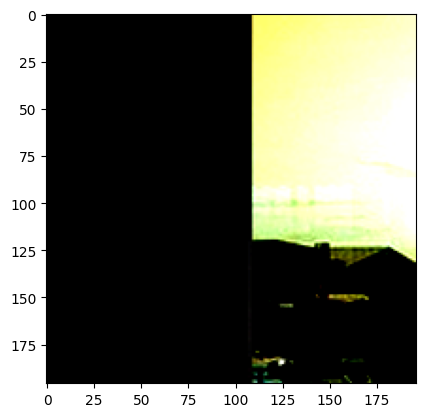

In [123]:
a = dataset[0]

In [17]:
a

(<PIL.Image.Image image mode=RGB size=375x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=375x500>)